In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Datasets/LWF_DATASET/lfw.zip

In [ ]:
!pip install -Uqq ipdb

     |████████████████████████████████| 788kB 10.1MB/s 
     |████████████████████████████████| 368kB 38.9MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.24.1 which is incompatible.


In [ ]:
import os
import torch
import cv2
import ipdb
import time 
import torchvision
import copy
import numpy as np
from torchvision.io import read_image
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),                    
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accuracy': val_acc}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    # save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_accuracy']
    print(f'Model loaded from <== {save_path}')
    
    return val_acc

In [ ]:
class customLFWDataset(Dataset):
  def __init__(self,img_dir,txt_path,transform=None,target_transform=None):
    self.img_dir=img_dir
    self.transform=transform
    self.target_transform=target_transform

    with open(txt_path,"r") as f:
      lines=f.readlines()
      img_pairs=[ line.split() for line in lines ]
      self.img_pairs=img_pairs

  def __len__(self):
    return len(self.img_pairs)

  def __getitem__(self,idx):
     chosen_pair=self.img_pairs[idx]
     img1_path= os.path.join(self.img_dir,chosen_pair[0])
     img2_path= os.path.join(self.img_dir,chosen_pair[1])
     label = float(chosen_pair[2])                                           ######## is a string
     
     img1=Image.open(img1_path)   # normalization included in PIL read
     img2=Image.open(img2_path)
    #  img1=read_image(img1_path)
    #  img2=read_image(img2_path)
    #  img1=cv2.imread(img1_path)
    #  img2=cv2.imread(img2_path)
     if self.transform:
       img1=self.transform(img1)
       img2=self.transform(img2)
     if self.target_transform:
       label=self.target_transform(np.array([label], dtype=np.float32))

     return img1,img2,label 

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    model_conv=torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
      param.requires_grad=False
    self.num_ftrs=model_conv.fc.in_features

    self.res_net_conv=torch.nn.Sequential(*(list(model_conv.children())[:-1]))

    self.fc=nn.Linear(self.num_ftrs*2,1)


  def forward(self,x1,x2):
    x1= self.res_net_conv(x1)
    x2= self.res_net_conv(x2)

    x1=x1.view(-1,self.num_ftrs)
    x2=x2.view(-1,self.num_ftrs)

    x=torch.cat((x1,x2),1)
    x=self.fc(x)

    # For distance function method
    # x=torch.abs(x1-x2)
    # x= self.fc2(x)

    return x

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([           ### have to ramove random crop if high bias found
        transforms.RandomResizedCrop(224),                          # crops the ip to random size and aspect ratio. Then resizes to given size.[Expected tensor shape (...,H,W)]
        transforms.RandomHorizontalFlip(),                                                                                     # horizontal flip, expects ip to be PIL / tensor
        transforms.ToTensor(),                           ### expects numpy array or PIL image not tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                                     # have to look into ???????????
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'label': torch.from_numpy                      ############################################# ??????????????/
}

path_lfw_folder='./gdrive/MyDrive/Datasets/LWF_DATASET' 
path_to_img_dir= './lfw/lfw'

train_txt_path = os.path.join(path_lfw_folder,'Final_lfw_train_pairs.txt')
valid_txt_path = os.path.join(path_lfw_folder,'Final_lfw_valid_pairs.txt')
test_txt_path  = os.path.join(path_lfw_folder,'Final_lfw_test_pairs.txt')                                                                     

txt_paths ={
    'train':train_txt_path,
    'val':valid_txt_path,
    'test':test_txt_path
}

image_datasets = {x: customLFWDataset(path_to_img_dir,txt_paths[x],data_transforms[x],data_transforms['label'] )  for x in ['train', 'val']} 

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

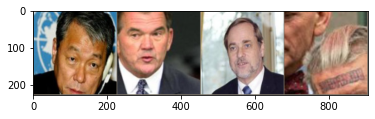

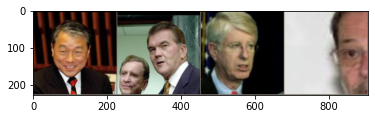

tensor([[1.],
        [1.],
        [0.],
        [0.]])


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])     
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                   
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
imgs1,imgs2, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out1 = torchvision.utils.make_grid(imgs1)         
imshow(out1)

out2 = torchvision.utils.make_grid(imgs2)         
imshow(out2)

print(labels)

In [ ]:
def train_model(model, criterion, optimizer, scheduler,save_name, num_epochs=1):      
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses_all={
        'train':[],
        'val':[]
    }
    accuracy_all={
        'train':[],
        'val':[]
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for imgs1,imgs2, labels in dataloaders[phase]:
                imgs1 = imgs1.to(device)
                imgs2 = imgs2.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs1,imgs2)                         ###### outputs= [[pred],[pred],[pred],...]
                    _, preds = torch.max(outputs, 1)                ###### preds =[ pred,pred,pred,...]
                    loss = criterion(outputs, labels)     ############### ?????????????
 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                # running_loss += loss.item() * inputs.size(0)              ####### ramove the factor and see :)
                running_corrects += torch.sum(preds == labels.data)        ###### what is there in labels.data ?
            if phase == 'train':
                scheduler.step()                                      ################################### ??????

            epoch_loss = running_loss / dataset_sizes[phase]          ###################
            losses_all[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_all[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(save_name, model, optimizer, best_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses_all,accuracy_all

In [ ]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

lr = 0.001  
num_epoches = 25    

model_conv = Net()    ###################################
model_conv = model_conv.to(device)

criterion = nn.BCEWithLogitsLoss()

# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Running on gpu


In [ ]:
count_parameters(model_conv)

The model architecture:

 Net(
  (res_net_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
save_path=os.path.join(path_lfw_folder,'siameseBaseModel.pt')      #   without using number factor in loss
model_conv,losses_dict,accuracy_dict = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, save_path,num_epoches)

Epoch 0/24
----------
train Loss: 0.1997 Acc: 1.9989
val Loss: 0.1763 Acc: 1.9879
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt

Epoch 1/24
----------
train Loss: 0.1954 Acc: 1.9989
val Loss: 0.2869 Acc: 1.9939
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt

Epoch 2/24
----------
train Loss: 0.1973 Acc: 2.0000
val Loss: 0.1839 Acc: 2.0000
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt

Epoch 3/24
----------
train Loss: 0.1938 Acc: 1.9989
val Loss: 0.2112 Acc: 1.9939

Epoch 4/24
----------
train Loss: 0.1989 Acc: 1.9979
val Loss: 0.1848 Acc: 2.0000

Epoch 5/24
----------
train Loss: 0.1969 Acc: 1.9989
val Loss: 0.1848 Acc: 1.9879

Epoch 6/24
----------
train Loss: 0.1846 Acc: 2.0000
val Loss: 0.2167 Acc: 1.9939

Epoch 7/24
----------
train Loss: 0.1709 Acc: 1.9989
val Loss: 0.1887 Acc: 2.0000

Epoch 8/24
----------
train Loss: 0.1685 Acc: 1.9989
val Loss: 0.1886 Acc: 1.9939

Epoch 9/24
----------


In [ ]:
################ Have to investigate how accuracy is getting calculated

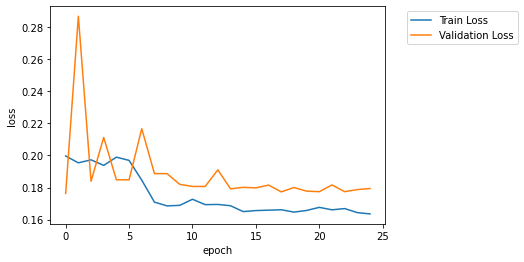

In [ ]:
#plotting of training and validation loss                          
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses_dict['train'], label='Train Loss')
plt.plot(losses_dict['val'], label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

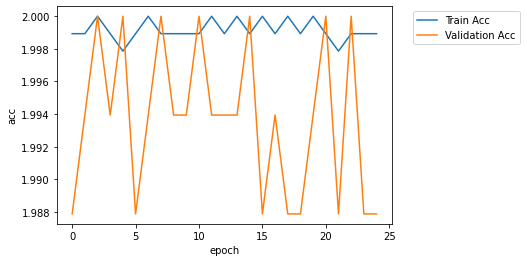

In [ ]:
#plotting of training and validation accu                          
plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(accuracy_dict['train'], label='Train Acc')
plt.plot(accuracy_dict['val'], label="Validation Acc")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training                  ###################################
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)          

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)           ###################################
                    return                                   ###################################
        model.train(mode=was_training)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()